In [1]:
import sys
import spotipy
import spotipy.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
import statsmodels.api as sm
import statsmodels.formula.api as sm
from surprise import Reader, Dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
def call_api(username, scope):
    token = util.prompt_for_user_token(username,scope,client_id='4849430a2b114eae9d8eaf2c1f14f612',client_secret='11b854b009344409861112df56d9cf44',redirect_uri='http://127.0.0.1:8050/dashboard') 
    return token

In [4]:
token = call_api('mrethana', 'user-top-read')
sp = spotipy.Spotify(auth=token)

In [5]:
def create_top_tracks_dict(period):
    list_tracks =[]
    for offset in range(0,500,49):
        x = sp.current_user_top_tracks(49,offset,period)
        temp = [track for track in x['items']]
        list_tracks.extend(temp)
#     import pdb; pdb.set_trace()
    top_track_dict = [{'album':item['album']['name'], 'album_id':item['album']['id'], 'album_release':item['album']['release_date'],'artist':item['artists'][0]['name'],'track_name':item['name'],'track_id':item['id']} for item in list_tracks]
    for item in list_tracks:
        for dic in top_track_dict:
            if item['id'] == dic['track_id']:
                if len(item['artists']) > 1:
                    dic['feature'] = item['artists'][1]['name']
                else:
                    dic['feature'] = 'No Feature'
    return top_track_dict
# lt = create_top_tracks_dict('long_term')





In [6]:
def all_features(dictionary):
    all_features = []
    for item in dictionary:
        all_features.extend(sp.audio_features(item['track_id']))
    return all_features
# lt_feat = all_features(lt)

def add_features(all_features, dictionary):
    for dic in dictionary:
        for item in all_features:
            if dic['track_id'] == item['id']:
                dic['danceability'] = item['danceability']
                dic['energy'] = item['energy']
                dic['loudness'] = item['loudness']
                dic['key'] = item['key']
                dic['acousticness'] = item['acousticness']
                dic['valence'] = item['valence']
                dic['tempo'] = item['tempo']



In [7]:
# def audio_analysis(id_list):
#     full_list = []
#     for id in id_list:
#         analysis = sp.audio_analysis(id)
#         inputs = analysis['segments']
#         analysis_dict = [{'pitches':round(sum(item['pitches'])/len(item['pitches']),1), 'timbre':round(sum(item['timbre'])/len(item['timbre']))} for item in inputs]
#         full_list.extend(analysis_dict)
#     return full_list
# #     analysis_dict = {'pitches': }
# #     item['pitches'] = sum(item['pitches'])/len(item['pitches'])
# #     item['timbre'] = sum(item['timbre'])/len(item['timbre'])
# x = audio_analysis(id_list_lt)
# df2 = pd.DataFrame(x)

In [8]:
lt = create_top_tracks_dict('long_term')
lt_feat = all_features(lt)
add_features(lt_feat, lt)
# st = create_top_tracks_dict('short_term')
# st_feat = all_features(st)
# add_features(st_feat, st)
# mt = create_top_tracks_dict('medium_term')
# mt_feat = all_features(mt)
# add_features(mt_feat, mt)

In [9]:
st = create_top_tracks_dict('short_term')
st_feat = all_features(st)
add_features(st_feat, st)


In [10]:
mt = create_top_tracks_dict('medium_term')
mt_feat = all_features(mt)
add_features(mt_feat, mt)

In [11]:
lt_df = pd.DataFrame(lt)
st_df = pd.DataFrame(st)
mt_df = pd.DataFrame(mt)

In [12]:
lt_df['rank'] = range(1, len(lt_df) + 1)
mt_df['rank'] = range(1, len(mt_df) + 1)
st_df['rank'] = range(1, len(st_df) + 1)

In [13]:
lt_df['percentile'] = pd.qcut(1 - lt_df['rank'],20,retbins = False, labels=False)
mt_df['percentile'] = pd.qcut(1 - mt_df['rank'],20,retbins = False, labels=False)
st_df['percentile'] = pd.qcut(1 - st_df['rank'],20,retbins = False, labels=False)

In [14]:
frames = [lt_df, st_df, mt_df]

all_df = pd.concat(frames)

In [18]:
all_df.to_csv('mrethana.csv')

In [20]:
df = pd.read_csv('mrethana.csv', index_col = 0)

In [22]:
df.corr()['percentile'].sort_values()

rank           -0.998756
energy         -0.120207
valence        -0.109025
tempo          -0.094232
loudness       -0.036002
danceability   -0.002787
acousticness    0.079451
key             0.090553
percentile      1.000000
Name: percentile, dtype: float64

In [40]:
category_df = all_df.select_dtypes('object')

In [ ]:
sns.cor

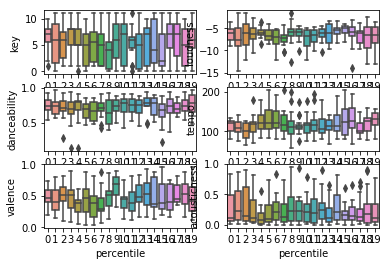

In [15]:
fig, axs = plt.subplots(ncols=2, nrows =3)
# sns.regplot(x='value', y='wage', data=df_melt, ax=axs[0])
# sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])
# sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])
sns.boxplot(x="percentile", y="key", data=all_df, ax=axs[0][0])
sns.boxplot(x="percentile", y="danceability", data=all_df, ax=axs[1][0])
sns.boxplot(x="percentile", y="valence", data=all_df, ax=axs[2][0])
sns.boxplot(x="percentile", y="loudness", data=all_df, ax=axs[0][1])
sns.boxplot(x="percentile", y="tempo", data=all_df, ax=axs[1][1])
sns.boxplot(x="percentile", y="acousticness", data=all_df, ax=axs[2][1])



In [16]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.scatter(x, y, s = s, alpha = alpha)
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [265]:
# def artists_tracks(artist_name):
#     final = []
#     for i in range(0,500,50):
#         temp = sp.search(artist_name, limit=50,offset = i, type = 'track')
#         results = temp['tracks']['items']
#         final.extend(results)
#     track_dict = [{'album':item['album']['name'], 'album_id':item['album']['id'], 'album_release':item['album']['release_date'],'artist':item['artists'][0]['name'],'track_name':item['name'],'track_id':item['id']} for item in final]
#     for item in final:
#         for dic in track_dict:
#             if item['id'] == dic['track_id']:
#                 if len(item['artists']) > 1:
#                     dic['feature'] = item['artists'][1]['name']
#             else:
#                 dic['feature'] = 'No Feature'
#     artist_dic = track_dict
#     feat = all_features(artist_dic)
#     add_features(feat, track_dict)
#     return artist_dic



In [63]:
token = call_api('mrethana', 'user-top-read')
sp = spotipy.Spotify(auth=token)

In [64]:
def artist_tracks_dict(artist_name):
    list_tracks =[]
    for offset in range(0,500,50):
        x = sp.search(artist_name, 50, offset, type = 'track')
        temp = [track for track in x['tracks']['items']]
        list_tracks.extend(temp)
    top_track_dict = [{'album':item['album']['name'], 'album_id':item['album']['id'], 'album_release':item['album']['release_date'],'artist':item['artists'][0]['name'],'track_name':item['name'],'track_id':item['id']} for item in list_tracks]
    for piece in list_tracks:
        for section in top_track_dict:
            if piece['id'] == section['track_id']:
                if len(piece['artists']) > 1:
                    section['feature'] = piece['artists'][1]['name']
                else:
                    section['feature'] = 'No Feature'
    example = top_track_dict
    feat = all_features(example)
    artist_features(feat,example)
    return top_track_dict

In [65]:
def artist_features(features_for_tracks, dictionary):
    for dic in dictionary:
        for item in features_for_tracks:
            if item == None:
                pass
            else:
                if dic['track_id'] == item['id']:
                    dic['danceability'] = item['danceability']
                    dic['energy'] = item['energy']
                    dic['loudness'] = item['loudness']
                    dic['key'] = item['key']
                    dic['acousticness'] = item['acousticness']
                    dic['valence'] = item['valence']
                    dic['tempo'] = item['tempo']


In [72]:
artist = artist_tracks_dict('troy sivan')


In [73]:
a_df = pd.DataFrame(artist)
a_df = a_df.query("artist == 'Troy Sivan'")
a_df


UndefinedVariableError: name 'artist' is not defined

In [571]:
display(a_df.head())
# display(lt_df.head())
# display(st_df.head())
# display(mt_df.head())

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence
6,0.0135,Parade - Music From The Motion Picture Under T...,54DjkEN3wdCQgfCTZ9WjdB,1986-03-31,Prince,0.898,0.271,No Feature,7,-12.238,111.485,62LJFaYihsdVrrkgUOJC05,Kiss,0.742
7,0.0353,Purple Rain,7nXJ5k4XgRj5OLg9m8V3zc,1984-06-25,Prince,0.367,0.452,No Feature,10,-10.422,113.066,54X78diSLoUDI3joC2bjMz,Purple Rain,0.189
8,0.0315,Prince,6k7RVZ7bSL9ryReb8RLYRI,1979-10-19,Prince,0.805,0.387,No Feature,8,-13.233,114.867,4yrM5BVyJzy5Ed4GPO6e8j,I Wanna Be Your Lover,0.701
10,0.0102,Purple Rain,7nXJ5k4XgRj5OLg9m8V3zc,1984-06-25,Prince,0.729,0.989,No Feature,9,-4.613,126.470,51H2y6YrNNXcy3dfc3qSbA,When Doves Cry,0.840
14,0.2100,Around The World In A Day,5FbrTPPlaNSOsChhKUZxcu,1985-04-22,Prince,0.761,0.670,No Feature,2,-12.759,120.752,5jSz894ljfWE0IcHBSM39i,Raspberry Beret,0.910


In [572]:
frames = [lt_df, st_df, mt_df]

all_songs = pd.concat(frames)
test_songs = all_songs.filter(['acousticness','danceability', 'key','energy','loudness','tempo','valence'])
labels = all_songs.filter(['rank percentile'])
test_songs['loudness'] = abs(test_songs['loudness'])
a_df_pred = a_df.filter(['acousticness','danceability', 'key','energy','loudness','tempo','valence','track_id'])
a_df_pred['loudness'] = abs(a_df_pred['loudness'])
a_df_pred = a_df_pred.dropna()
a_df = a_df.dropna()
a_df_pred_use = a_df_pred.filter(['acousticness','danceability', 'key','energy','loudness','tempo','valence'])
len(a_df_pred_use)

124

In [573]:
split_tracks = train_test_split(test_songs, labels)
X_train, X_test, y_train, y_test = split_tracks[0], split_tracks[1], split_tracks[2], split_tracks[3]

In [574]:
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train, y_train)
mnb_preds = mnb_clf.predict(X_test)
mnb_testing_accuracy = accuracy_score(y_test, mnb_preds)

print("Testing Accuracy for Reccomendation: {:.4}%".format(mnb_testing_accuracy * 100))

Testing Accuracy for Reccomendation: 8.108%


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [575]:
recs = mnb_clf.predict(a_df_pred_use)
rec_df = pd.DataFrame(recs, columns = ['value'])
list_recs =rec_df.loc[rec_df['value'] == 0]
array = list_recs.index.tolist()
array_2 = []
for i in array:
     array_2.append(i - 1)

In [576]:
len(recs)

124

In [577]:
array_2

[2, 8, 9, 14, 23, 31, 46, 50, 72, 88, 91, 94, 95, 109]

In [578]:
a_df['match'] = range(1, len(a_df) + 1)

In [579]:
rec_df = a_df[a_df['match'].isin(array_2)]


In [580]:
rec_df

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence,match
7,0.035300,Purple Rain,7nXJ5k4XgRj5OLg9m8V3zc,1984-06-25,Prince,0.367,0.452,No Feature,10,-10.422,113.066,54X78diSLoUDI3joC2bjMz,Purple Rain,0.189,2
31,0.086200,Purple Rain,7nXJ5k4XgRj5OLg9m8V3zc,1984-06-25,Prince,0.731,0.750,No Feature,2,-10.457,135.406,6fBwVe6udYdnRqwqo06if8,I Would Die 4 U,0.639,8
34,0.235000,4Ever,7mhrGQKxLFJPY2J4TXtA0A,2016-11-22,Prince,0.777,0.700,No Feature,1,-11.045,122.940,6X4JeTWCuKEzKOEHXDtyBo,Little Red Corvette,0.802,9
66,0.409000,Prince,6k7RVZ7bSL9ryReb8RLYRI,1979-10-19,Prince,0.705,0.342,No Feature,11,-13.209,79.904,3QwN6nANXiVnexlOMXQNp7,It's Gonna Be Lonely,0.274,14
95,0.053200,Diamonds And Pearls,0qcgEPOg67XnxGizdAAcGa,1991-10-01,Prince,0.549,0.547,No Feature,7,-10.119,81.050,7IoLw1bECmOSWcm2u9SmRH,Diamonds And Pearls,0.288,23
123,0.293000,Batman,2FwzHgJ4XaPhC19Y0uL6SK,1989-06-20,Prince,0.761,0.404,No Feature,1,-11.977,124.524,2dnPoLlcwJFtFm1pps3Bm0,Scandalous,0.509,31
162,0.228000,For You,5kbRcoeBHpJHe37a9agmfv,1978-04-07,Prince,0.904,0.463,No Feature,6,-11.552,115.362,6Q8s3YuAWkx0Qui0Jgkr5m,Soft and Wet,0.926,46
178,0.000406,Dirty Mind,3Cijd5OjHeWBm97DsPHpgs,1980-10-08,Prince,0.849,0.385,No Feature,0,-14.398,125.408,3IiS3fVdtsMPSHsWBgDcFn,Uptown,0.886,50
258,0.017800,The Very Best Of Prince,5oQClEU6YXiVoaz4ZTmOOO,2001-07-30,Prince,0.875,0.882,No Feature,9,-11.219,126.574,7ffE3UYWppPyCRTfIrA3nf,When Doves Cry,0.874,72
325,0.169000,The Hits/The B-Sides,3o0o5WPnqfGOeyx3UMJgvO,1993-09-13,Prince,0.770,0.744,No Feature,2,-8.133,106.150,4Syn1a4Irz0UbbR44s7CqB,Sexy M.F.,0.548,88


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124949eb8>,
      dtype=object)

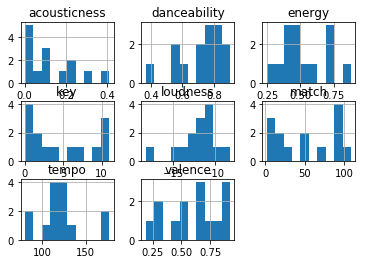

In [581]:
rec_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115b7d048>,
      dtype=object)

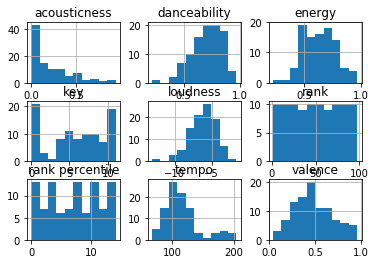

In [508]:
lt_df.hist()

In [ ]:
user_playlist_create

In [ ]:
user_playlist_add_tracks(self, user, playlist_id, tracks,
                                 position=None)

In [582]:
rec_df

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence,match
7,0.035300,Purple Rain,7nXJ5k4XgRj5OLg9m8V3zc,1984-06-25,Prince,0.367,0.452,No Feature,10,-10.422,113.066,54X78diSLoUDI3joC2bjMz,Purple Rain,0.189,2
31,0.086200,Purple Rain,7nXJ5k4XgRj5OLg9m8V3zc,1984-06-25,Prince,0.731,0.750,No Feature,2,-10.457,135.406,6fBwVe6udYdnRqwqo06if8,I Would Die 4 U,0.639,8
34,0.235000,4Ever,7mhrGQKxLFJPY2J4TXtA0A,2016-11-22,Prince,0.777,0.700,No Feature,1,-11.045,122.940,6X4JeTWCuKEzKOEHXDtyBo,Little Red Corvette,0.802,9
66,0.409000,Prince,6k7RVZ7bSL9ryReb8RLYRI,1979-10-19,Prince,0.705,0.342,No Feature,11,-13.209,79.904,3QwN6nANXiVnexlOMXQNp7,It's Gonna Be Lonely,0.274,14
95,0.053200,Diamonds And Pearls,0qcgEPOg67XnxGizdAAcGa,1991-10-01,Prince,0.549,0.547,No Feature,7,-10.119,81.050,7IoLw1bECmOSWcm2u9SmRH,Diamonds And Pearls,0.288,23
123,0.293000,Batman,2FwzHgJ4XaPhC19Y0uL6SK,1989-06-20,Prince,0.761,0.404,No Feature,1,-11.977,124.524,2dnPoLlcwJFtFm1pps3Bm0,Scandalous,0.509,31
162,0.228000,For You,5kbRcoeBHpJHe37a9agmfv,1978-04-07,Prince,0.904,0.463,No Feature,6,-11.552,115.362,6Q8s3YuAWkx0Qui0Jgkr5m,Soft and Wet,0.926,46
178,0.000406,Dirty Mind,3Cijd5OjHeWBm97DsPHpgs,1980-10-08,Prince,0.849,0.385,No Feature,0,-14.398,125.408,3IiS3fVdtsMPSHsWBgDcFn,Uptown,0.886,50
258,0.017800,The Very Best Of Prince,5oQClEU6YXiVoaz4ZTmOOO,2001-07-30,Prince,0.875,0.882,No Feature,9,-11.219,126.574,7ffE3UYWppPyCRTfIrA3nf,When Doves Cry,0.874,72
325,0.169000,The Hits/The B-Sides,3o0o5WPnqfGOeyx3UMJgvO,1993-09-13,Prince,0.770,0.744,No Feature,2,-8.133,106.150,4Syn1a4Irz0UbbR44s7CqB,Sexy M.F.,0.548,88


In [583]:
return_to_dict = rec_df['artist'].to_dict()
artist_name = list(return_to_dict.values())[0]
artist_name

'Prince'

In [584]:
id_add = list(rec_df['track_id'].to_dict().values())

In [557]:
# sp2.user_playlists('mrethana')['items'][0]['id']

'0W8XF2llnx3Hx35dbwVgDj'

In [585]:
token2 = call_api('mrethana', 'playlist-modify-public')
sp2 = spotipy.Spotify(auth=token2)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=4849430a2b114eae9d8eaf2c1f14f612&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A8050%2Fdashboard&scope=playlist-modify-public in your browser


Enter the URL you were redirected to: http://127.0.0.1:8050/dashboard?code=AQAYWk2-6AcIGQm1clnXrsswXCa0QqbypHBA7_TNN1htdAA71xcia94VRp_-uHRo2J2j0a_mjs-B8xqm7ar4P-j6ycO9Pz0qmTpRzbvOhlLGuvy-G17Ul5z5PC6H74HFurSHtdmrJ5DwbbbMPppsRfRTuzqHeQj_eZHJezJFvVxinir0FV2tdbeBFaG6v7V9CyCkfx6bSYr7YPavTbhpFJ84FDMlKZj5hrEmhPM




In [586]:
sp2.user_playlist_create('mrethana',artist_name, True)

{'collaborative': False,
 'description': None,
 'external_urls': {'spotify': 'https://open.spotify.com/user/mrethana/playlist/2458TWO4rrDwD2BquzCExd'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/users/mrethana/playlists/2458TWO4rrDwD2BquzCExd',
 'id': '2458TWO4rrDwD2BquzCExd',
 'images': [],
 'name': 'Prince',
 'owner': {'display_name': None,
  'external_urls': {'spotify': 'https://open.spotify.com/user/mrethana'},
  'href': 'https://api.spotify.com/v1/users/mrethana',
  'id': 'mrethana',
  'type': 'user',
  'uri': 'spotify:user:mrethana'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSxjNjVmYzExYWQ4NTZiMWRjMmI5MGRjNmMwNmMwYzM4OWU3NjE4YzZk',
 'tracks': {'href': 'https://api.spotify.com/v1/users/mrethana/playlists/2458TWO4rrDwD2BquzCExd/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:user:mrethana:playlist:2458TWO4rrDwD2BquzCExd'}

In [587]:
newest_id = sp2.user_playlists('mrethana')['items'][0]['id']

In [588]:
sp2.user_playlist_add_tracks('mrethana', newest_id, id_add, None)

{'snapshot_id': 'Miw3ODZjYTJmNDIwYjg1YTRjYzBhMzI3ZDM0Zjk0YzMwYmFhOTYyMDEz'}

In [9]:
saved_tracks = sp2.current_user_saved_tracks(50,5)
# saved_tracks = [track['track'] for track in saved_tracks['items']]
# artist_lists = []
# for artist_list in saved_tracks:
#     artist_lists.extend(artist_list['artists'])

In [419]:
# x = set([artist['id'] for artist in artist_lists])


In [420]:
# all_artists = [person['name'] for person in sp.artists(x)['artists']]
list_name[-6]

'The Way You Make Me Feel - 2012 Remaster'

In [421]:
list_tracks[0]
list_tracks[1]
sp.artist_top_tracks('1W7FNibLa0O0b572tB2w7t')['tracks'][0]['name']


'Honesty'

In [399]:
pink = sp.audio_analysis('5dXI2NV7X2c4anyLFbQdEX')
weekend = sp.audio_analysis(list_tracks[-6])
dangerous = sp.audio_analysis(list_tracks[1])
for pitch_list in dangerous['segments']:
    pitch_list['pitches'] = sum(pitch_list['pitches'])/len(pitch_list['pitches'])
    pitch_list['timbre'] = sum(pitch_list['timbre'])/len(pitch_list['timbre'])
for pitch_list in weekend['segments']:
    pitch_list['pitches'] = sum(pitch_list['pitches'])/len(pitch_list['pitches'])
    pitch_list['timbre'] = sum(pitch_list['timbre'])/len(pitch_list['timbre'])
    
for pitch_list in pink['segments']:
    pitch_list['pitches'] = sum(pitch_list['pitches'])/len(pitch_list['pitches'])
    pitch_list['timbre'] = sum(pitch_list['timbre'])/len(pitch_list['timbre'])
    
dw = pd.DataFrame(dangerous['segments'])
we = pd.DataFrame(weekend['segments'])
ps = pd.DataFrame(pink['segments'])

# pitches = pd.DataFrame(df['pitches'])
# pitches
dw['timbre'].tail()

744     6.283750
745    11.938333
746     0.095667
747    -0.962500
748     6.358417
Name: timbre, dtype: float64

In [400]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



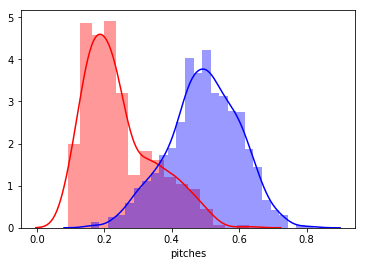

In [401]:
sns.distplot(ps['pitches'],color = 'red')
sns.distplot(we['pitches'], color = 'blue')


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



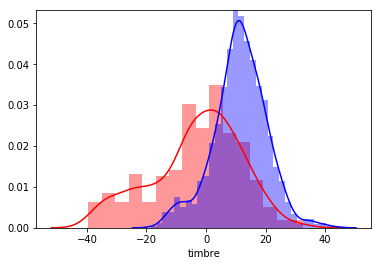

In [402]:
sns.distplot(ps['timbre'], color = 'red')
sns.distplot(we['timbre'], color = 'blue')

In [403]:
import pandas as pd
wsections = pd.DataFrame(weekend['sections'])
dsections = pd.DataFrame(dangerous['sections'])

In [404]:
psdf = pd.DataFrame(pink['sections'])
psdf.describe()

,confidence,duration,key,key_confidence,loudness,mode,mode_confidence,start,tempo,tempo_confidence,time_signature,time_signature_confidence
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000
mean,0.342000,21.222223,8.555556,0.223556,-14.114667,0.333333,0.380556,103.927190,80.049667,0.554667,4.0,0.977333
std,0.302116,12.998185,2.505549,0.308065,7.558723,0.500000,0.312643,61.950544,0.612873,0.135907,0.0,0.045970
min,0.090000,9.368490,6.000000,0.000000,-30.585000,0.000000,0.000000,0.000000,79.445000,0.335000,4.0,0.879000
25%,0.143000,9.854780,6.000000,0.006000,-14.103000,0.000000,0.029000,53.889640,79.633000,0.500000,4.0,1.000000
50%,0.212000,15.015200,9.000000,0.048000,-10.880000,0.000000,0.560000,122.121140,79.937000,0.515000,4.0,1.000000
75%,0.374000,29.517760,11.000000,0.457000,-9.631000,1.000000,0.617000,141.595070,80.128000,0.643000,4.0,1.000000
max,1.000000,40.490150,11.000000,0.753000,-8.207000,1.000000,0.750000,181.631510,81.445000,0.764000,4.0,1.000000


In [405]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

data = [go.Scatter(
          x=psdf.start,
          y=psdf.tempo)]

py.iplot(data)

In [406]:
sp.audio_features('5dXI2NV7X2c4anyLFbQdEX')

[{'danceability': 0.616,
  'energy': 0.204,
  'key': 6,
  'loudness': -11.421,
  'mode': 0,
  'speechiness': 0.0331,
  'acousticness': 0.919,
  'instrumentalness': 0,
  'liveness': 0.106,
  'valence': 0.419,
  'tempo': 79.826,
  'type': 'audio_features',
  'id': '5dXI2NV7X2c4anyLFbQdEX',
  'uri': 'spotify:track:5dXI2NV7X2c4anyLFbQdEX',
  'track_href': 'https://api.spotify.com/v1/tracks/5dXI2NV7X2c4anyLFbQdEX',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5dXI2NV7X2c4anyLFbQdEX',
  'duration_ms': 191000,
  'time_signature': 4}]